# Variational Auto-Encoders

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [3]:
batch_size = 100
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [46]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu)
    
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2)

if torch.cuda.is_available():
    vae.cuda()



In [47]:
optimizer = optim.Adam(vae.parameters())
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [48]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx,  (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data.float()
        recon_batch, mu, log_var = vae(data)
        
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print("Epoch : ", epoch, " Loss : ", train_loss)
    

In [49]:
def test():
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            recon, mu, log_var = vae(data)
            
            test_loss += loss_function(recon, data, mu, log_var).item()
    test_loss /= len(test_loader.dataset)
    print("Test loss : ", test_loss)

In [50]:
for epoch in range(1, 51):
    train(epoch)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :  1  Loss :  10750853.161132812
Epoch :  2  Loss :  9565705.342773438
Epoch :  3  Loss :  9243505.092773438
Epoch :  4  Loss :  9049539.201171875
Epoch :  5  Loss :  8897338.5703125
Epoch :  6  Loss :  8811529.49609375
Epoch :  7  Loss :  8757011.889648438
Epoch :  8  Loss :  8697597.770507812
Epoch :  9  Loss :  8639360.56640625
Epoch :  10  Loss :  8605744.4375
Epoch :  11  Loss :  8572931.354492188
Epoch :  12  Loss :  8535270.368164062
Epoch :  13  Loss :  8512760.9140625
Epoch :  14  Loss :  8475203.25390625
Epoch :  15  Loss :  8458171.072265625
Epoch :  16  Loss :  8431097.243164062
Epoch :  17  Loss :  8414519.661132812
Epoch :  18  Loss :  8394828.34765625
Epoch :  19  Loss :  8378001.04296875
Epoch :  20  Loss :  8366855.0908203125
Epoch :  21  Loss :  8354189.6826171875
Epoch :  22  Loss :  8334626.91796875
Epoch :  23  Loss :  8322845.3359375
Epoch :  24  Loss :  8303810.7529296875
Epoch :  25  Loss :  8295503.5283203125
Epoch :  26  Loss :  8277694.4189453125
Epoch 

In [61]:
import matplotlib.pyplot as plt
import cv2
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z)
#     plt.imshow(sample.view(64, 1, 28, 28))
    save_image(sample.view(64, 1, 28, 28)[0], './sample_' + '.png')

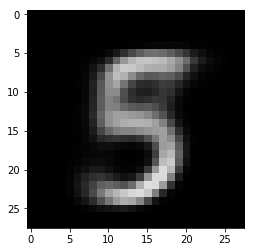

In [62]:
img = cv2.imread('./sample_.png')
plt.imshow(img)